In [1]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import torch.nn.utils.prune as prune

import PIL
from PIL import Image
from torch.utils.data import DataLoader

from collections import OrderedDict, defaultdict
 
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")
device

device(type='cuda', index=0)

parameters

In [2]:
n_epochs = 50
batch_size_train = 100
batch_size_test = 1000
#learning_rate = 0.01
#momentum = 0.5
log_interval = 50000 / (10 * batch_size_train)
random_seed = 1
torch.manual_seed(random_seed)

CIFAR10 loader

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 #(0.1307,), (0.3081,))
                                 #(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 #(0.1307,), (0.3081,))
                                 #(0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                             ])),
  batch_size=batch_size_test, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from train_test import test, train_model, plot_loss_and_accuracy
from model import model, add_dropout_or_batchnorm, remove_dropout_or_batchnorm
from utils import get_accuracies, get_accuracies_pd, acc_on_batch, running_stats, running_stats_batch
from pruning import get_pruned_model
from collections import defaultdict
from model_resizing import resize_model

## 1. Исходная nn model

In [5]:
net = model()

Добавляем дропауты и батчнормы в исходную модель

In [6]:
models = {}
models['net_--_--'] = net.to(device) # исходная модель
models['net_1d_--'] = add_dropout_or_batchnorm(net, add_dropout=True).to(device) # модель с дропаутом
models['net_--_1b'] = add_dropout_or_batchnorm(net, add_batchnorm=True).to(device) # модель с батчнормом
models['net_1d_1b'] = add_dropout_or_batchnorm(net, add_dropout=True, add_batchnorm=True).to(device) # модель с дропаутом и батчнормом

In [6]:
! pip install validators

  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19567 sha256=d27d800579c18a17c892e44466a5593ae452d96ed315c03fc52fd98e61a55815
  Stored in directory: c:\users\kirill\appdata\local\pip\cache\wheels\19\09\72\3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators


In [12]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

Using cache found in C:\Users\kirill/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kirill/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [13]:
efficientnet.classifier.fc = torch.nn.Linear(in_features=1280, out_features=10, bias=True)

In [14]:
for param in efficientnet.parameters():
    param.requires_grad = False

In [15]:
for param in efficientnet.classifier.fc.parameters():
    param.requires_grad = True

Скачиваем обученные модели

In [ ]:
# обучение моделей с нуля: 
models = {'efficient_net': efficientnet}
for model_name in models:
    print(model_name)
    training_results = train_model(models[model_name], model_name, train_loader, test_loader, 
                                   n_epochs=10, learning_rate=1e-3, device=device)
    plot_loss_and_accuracy(training_results)

efficient_net
Test set: Avg. loss: 0.0159, Accuracy: 917/10000 (9.17%)


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 [0/50000 (0%)]	Loss: -0.022720
Train Epoch: 0 [5000/50000 (10%)]	Loss: 1.239052
Train Epoch: 0 [10000/50000 (20%)]	Loss: 1.655922
Train Epoch: 0 [15000/50000 (30%)]	Loss: 0.144081
Train Epoch: 0 [20000/50000 (40%)]	Loss: -2.871054
Train Epoch: 0 [25000/50000 (50%)]	Loss: -7.798275
Train Epoch: 0 [30000/50000 (60%)]	Loss: -13.429722
Train Epoch: 0 [35000/50000 (70%)]	Loss: -17.472912
Train Epoch: 0 [40000/50000 (80%)]	Loss: -20.077278
Train Epoch: 0 [45000/50000 (90%)]	Loss: -31.270502
Train set: Avg. loss: -16.7054, Accuracy: 16330/50000 (32.66%)
Test set: Avg. loss: -29.7164, Accuracy: 3529/10000 (35.29%)
Train Epoch: 1 [0/50000 (0%)]	Loss: -32.857697
Train Epoch: 1 [5000/50000 (10%)]	Loss: -32.409416
Train Epoch: 1 [10000/50000 (20%)]	Loss: -36.856956
Train Epoch: 1 [15000/50000 (30%)]	Loss: -31.052996
Train Epoch: 1 [20000/50000 (40%)]	Loss: -48.541969
Train Epoch: 1 [25000/50000 (50%)]	Loss: -43.835342
Train Epoch: 1 [30000/50000 (60%)]	Loss: -49.360672
Train Epoch: 

In [ ]:
torch.save(models[0], 'efficientnet_trained')

net_--_--


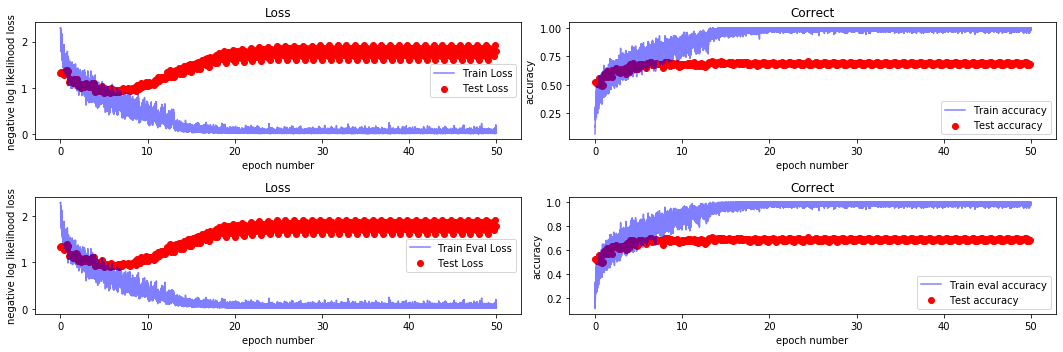

net_--_1b


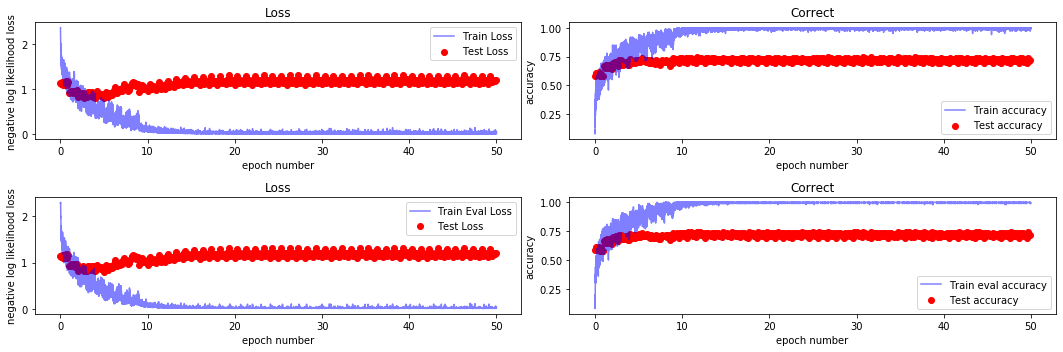

net_1d_--


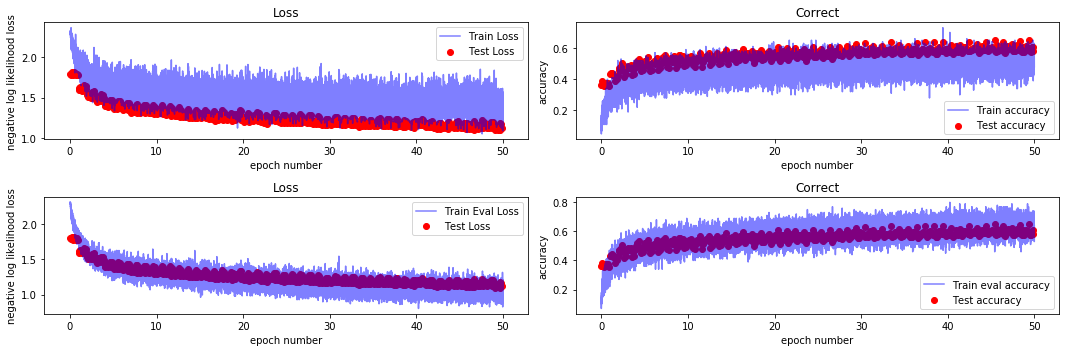

net_1d_1b


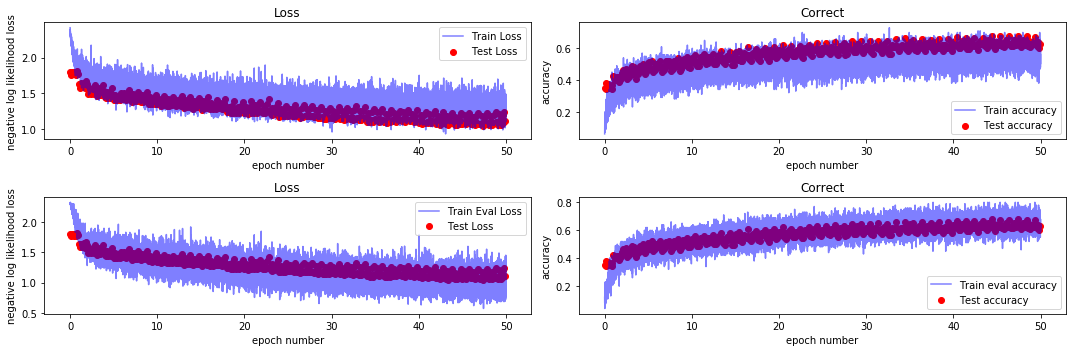

In [60]:
epoch = 49
for model_name in ['net_--_--', 'net_--_1b']: # переобученные модели
    print(model_name)
    training_results = torch.load(f'./checkpoints/CIFAR10/{model_name}/{epoch}.pth')
    models[model_name].load_state_dict(training_results['model_state_dict'])
    plot_loss_and_accuracy(training_results)
    
epoch = 49
for model_name in ['net_1d_--','net_1d_1b']: # непереобучаемые модели  
    print(model_name)
    training_results = torch.load(f'./checkpoints/CIFAR10/{model_name}/{epoch}.pth')
    models[model_name].load_state_dict(training_results['model_state_dict']) 
    plot_loss_and_accuracy(training_results)    


In [61]:
# поскольку первые две модели переобучены, возьмём из истории эпоху поменьше:
# оптимальные 7 и 4 эпохи соответственно:
models['net_--_--'].load_state_dict(torch.load(f'./checkpoints/CIFAR10/net_--_--/7.pth')['model_state_dict'])
models['net_--_1b'].load_state_dict(torch.load(f'./checkpoints/CIFAR10/net_--_1b/4.pth')['model_state_dict'])

<All keys matched successfully>

Убираем часть дропаутов и батчнормов

In [62]:
models['net_0d_--'] = remove_dropout_or_batchnorm(models['net_1d_--'], remove_dropout=True)
models['net_--_0b'] = remove_dropout_or_batchnorm(models['net_--_1b'], remove_batchnorm=True)
models['net_0d_1b'] = remove_dropout_or_batchnorm(models['net_1d_1b'], remove_dropout=True)
models['net_1d_0b'] = remove_dropout_or_batchnorm(models['net_1d_1b'], remove_batchnorm=True)
models['net_0d_0b'] = remove_dropout_or_batchnorm(models['net_1d_1b'], remove_batchnorm=True, remove_dropout=True)

Точности всех моделей

In [63]:
get_accuracies_pd(models, test_loader, device)

Model Name,Accuracy eval,Accuracy train,Loss eval,Loss train
net_--_--,67.69,67.69,0.965791,0.965791
net_1d_--,60.01,49.13,1.13015,1.45895
net_--_1b,70.78,71.37,0.877699,0.864944
net_1d_1b,63.13,55.07,1.1266,1.29663
net_0d_--,60.01,60.01,1.13015,1.13015
net_--_0b,25.88,25.88,2.1246,2.1246
net_0d_1b,63.13,64.66,1.1266,1.06907
net_1d_0b,52.8,38.26,79.4425,183.031
net_0d_0b,52.8,52.8,79.4425,79.4425


In [31]:
for model in models:
    get_accuracies(models[model], test_loader, model)

net_--_--
Accuracy in eval mode:  test loss: 0.9177, accuracy: 6900/10000 (69.00%)
Accuracy in train mode: test loss: 0.9177, accuracy: 6900/10000 (69.00%)
____________________________________________
net_1d_--
Accuracy in eval mode:  test loss: 1.0257, accuracy: 6456/10000 (64.56%)
Accuracy in train mode: test loss: 1.3746, accuracy: 5302/10000 (53.02%)
____________________________________________
net_--_1b
Accuracy in eval mode:  test loss: 0.8463, accuracy: 7067/10000 (70.67%)
Accuracy in train mode: test loss: 0.8458, accuracy: 7075/10000 (70.75%)
____________________________________________
net_1d_1b
Accuracy in eval mode:  test loss: 1.0333, accuracy: 6715/10000 (67.15%)
Accuracy in train mode: test loss: 1.2458, accuracy: 5687/10000 (56.87%)
____________________________________________
net_0d_--
Accuracy in eval mode:  test loss: 1.0257, accuracy: 6456/10000 (64.56%)
Accuracy in train mode: test loss: 1.0257, accuracy: 6456/10000 (64.56%)
________________________________________

## 2. Прунинг

In [68]:
pruned_models = {}
for model_name in models:
    pruned_models['pruned_' + model_name] = get_pruned_model(models[model_name], amount=0.2)
get_accuracies_pd(pruned_models, test_loader, device)

Model Name,Accuracy eval,Accuracy train,Loss eval,Loss train
pruned_net_--_--,63.46,63.46,1.05472,1.05472
pruned_net_1d_--,46.2,34.74,1.71389,1.91903
pruned_net_--_1b,36.62,55.83,2.00668,1.35662
pruned_net_1d_1b,44.09,28.59,1.73947,2.15474
pruned_net_0d_--,46.2,46.2,1.71389,1.71389
pruned_net_--_0b,17.3,17.3,2.24503,2.24503
pruned_net_0d_1b,46.46,62.82,1.55829,1.0738
pruned_net_1d_0b,52.13,33.37,29.5335,86.3407
pruned_net_0d_0b,52.13,52.13,29.5335,29.5335


In [69]:
# у отпруненных моделей нельзя сделать deepcopy, так как добавились новые ключи в state-dict,
# поэтому после resize меняется pruned модель и могут возникать ошибки 
resized_models = {}
for model_name in models:
    print(model_name)
    resized_models['resized_' + model_name] =\
        resize_model(pruned_models['pruned_' + model_name], device=device)
    
get_accuracies_pd(resized_models, test_loader, device=device)

net_--_--
net_1d_--
net_--_1b
net_1d_1b
net_0d_--
net_--_0b
net_0d_1b
net_1d_0b
net_0d_0b


Model Name,Accuracy eval,Accuracy train,Loss eval,Loss train
resized_net_--_--,61.52,61.52,1.11004,1.11004
resized_net_1d_--,53.68,41.41,1.41464,1.68376
resized_net_--_1b,51.27,55.61,1.47322,1.37267
resized_net_1d_1b,27,42.63,4.11935,1.65246
resized_net_0d_--,53.68,53.68,1.41464,1.41464
resized_net_--_0b,18.25,18.25,2.23518,2.23518
resized_net_0d_1b,55.93,61.03,1.3213,1.14664
resized_net_1d_0b,55.62,36.73,25.0056,72.3569
resized_net_0d_0b,55.62,55.62,25.0056,25.0056


In [70]:
eval_acc = defaultdict(list)
train_acc = defaultdict(list)
means_rel = defaultdict(defaultdict)
vars_rel = defaultdict(defaultdict)
for res_model in resized_models:
    eval_acc[res_model], train_acc[res_model], means_rel[res_model], vars_rel[res_model] =\
        running_stats_batch(resized_models[res_model], train_loader, device)

In [71]:
get_accuracies_pd(resized_models, test_loader, device)

Model Name,Accuracy eval,Accuracy train,Loss eval,Loss train
resized_net_--_--,61.52,61.52,1.11004,1.11004
resized_net_1d_--,53.68,41.87,1.41464,1.68684
resized_net_--_1b,55.45,55.61,1.37279,1.37267
resized_net_1d_1b,58.59,43.13,1.24276,1.65084
resized_net_0d_--,53.68,53.68,1.41464,1.41464
resized_net_--_0b,18.25,18.25,2.23518,2.23518
resized_net_0d_1b,61.25,61.03,1.14981,1.14664
resized_net_1d_0b,55.62,36.98,25.0056,74.2127
resized_net_0d_0b,55.62,55.62,25.0056,25.0056


In [ ]:
def get_accuracies_pd_prune_amounts(models, loader, device):
    columns = [ 'Accuracy eval', 'Accuracy train']
    index = [m for m in models]
    data = pd.DataFrame(index=index, columns=columns)
    total_len = len(loader.dataset)
    for i, model in enumerate(models):
        test_loss, correct = test(models[model], loader, device=device, is_print=False)
        data['Loss eval'].iloc[i] = np.mean(test_loss)
        data['Accuracy eval'].iloc[i] = 100. * np.sum(correct) / total_len
        test_loss, correct = test(models[model], loader, device=device, is_train=True, is_print=False)
        data['Loss train'].iloc[i] = np.mean(test_loss)
        data['Accuracy train'].iloc[i] = 100. * np.sum(correct) / total_len
    return data.rename_axis('Model Name', axis=1)

Text(0.5, 1.0, 'Отношение нормы дисперсии на данном батче к первому батчу')

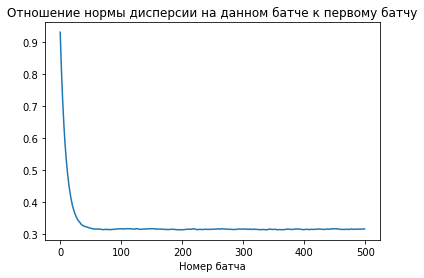

In [38]:
plt.plot(vars_rel['resized_net_0d_1b'][1])
#plt.plot(train_acc)
plt.xlabel('Номер батча')
plt.title('Отношение нормы дисперсии на данном батче к первому батчу')
#plt.savefig('Vars relativity', dpi=300)

Text(0.5, 1.0, 'Отношение нормы дисперсии на данном батче к первому батчу')

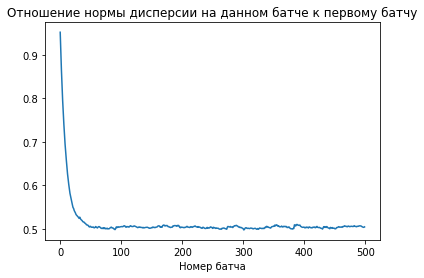

In [39]:
plt.plot(vars_rel['resized_net_--_1b'][1])
plt.xlabel('Номер батча')
plt.title('Отношение нормы дисперсии на данном батче к первому батчу')

Text(0.5, 1.0, 'Отношение нормы дисперсии на данном батче к первому батчу')

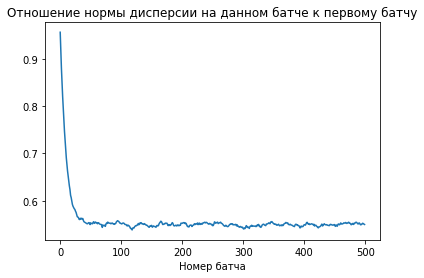

In [40]:
plt.plot(vars_rel['resized_net_1d_1b'][1])
plt.xlabel('Номер батча')
plt.title('Отношение нормы дисперсии на данном батче к первому батчу')

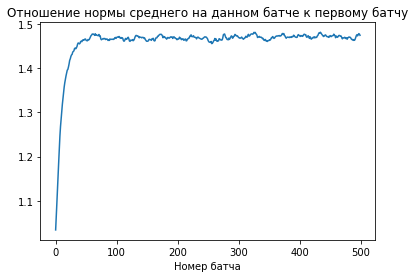

In [41]:
plt.plot(means_rel['resized_net_0d_1b'][1])
plt.xlabel('Номер батча')
plt.title('Отношение нормы среднего на данном батче к первому батчу')

plt.savefig('Mean relativity', dpi=300)

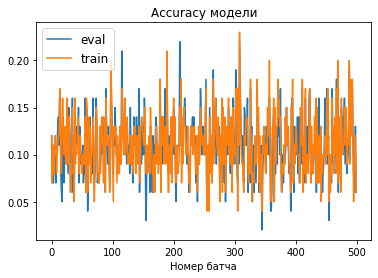

In [42]:
plt.plot(eval_acc['resized_net_0d_1b'], label='eval')
plt.plot(train_acc['resized_net_0d_1b'], label='train')
plt.xlabel('Номер батча')
plt.title('Accuracy модели')
plt.legend(prop={'size': 12})
plt.savefig('Accuracy eval and train', dpi=300)

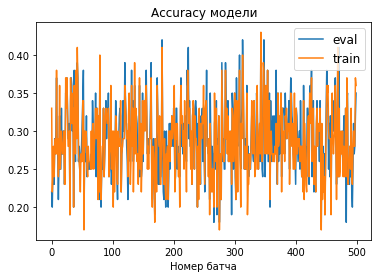

In [43]:
plt.plot(eval_acc['resized_net_--_1b'], label='eval')
plt.plot(train_acc['resized_net_--_1b'], label='train')
plt.xlabel('Номер батча')
plt.title('Accuracy модели')
plt.legend(prop={'size': 12})
plt.savefig('Accuracy eval and train', dpi=300)

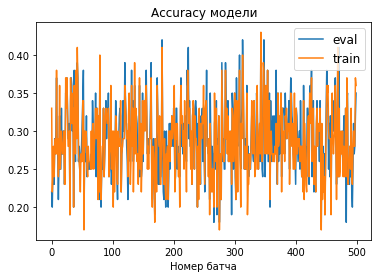

In [44]:
plt.plot(eval_acc['resized_net_--_1b'], label='eval')
plt.plot(train_acc['resized_net_--_1b'], label='train')
plt.xlabel('Номер батча')
plt.title('Accuracy модели')
plt.legend(prop={'size': 12})
plt.savefig('Accuracy eval and train', dpi=300)   